# **Bag of words classification: Week 1**

## Team 9
Members:
- **Hicham El Muhandiz Aarab**
- **Julia Ariadna Blanco Arnaus**

## Introduction
In this project we try to classify MIT dataset images into their correct class using the Bag of Visual Words model. We extract the features from the images, and we agreggate them. Then, we train a classifier to output the label corresponding to the image category.



Let's import the required libraries for the project

In [ ]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.pyplot as plt


from IPython.display import display
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_validate, GridSearchCV

In [ ]:
#install opencv version that allows using sift
!pip install opencv-contrib-python==4.4.0.44

#load database from drive
from google.colab import drive
drive.mount('/content/drive')
filepath = './drive/My Drive'


#load database locally
#filepath = '..'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us first read the train and test files

In [ ]:
train_images_filenames = pickle.load(open(filepath+'/MIT_split/'+'train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open(filepath+'/MIT_split/'+'test_images_filenames.dat','rb'))
train_images_filenames = [filepath + n[15:] for n in train_images_filenames]
test_images_filenames  = [filepath + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open(filepath+'/MIT_split/''train_labels.dat','rb')) 
test_labels = pickle.load(open(filepath+'/MIT_split/''test_labels.dat','rb'))

In [ ]:
train_images_filenames[12]

'./drive/My Drive/MIT_split/train/Opencountry/fie26.jpg'

Let's visualize the images in the the dataset:




Training set
Number of samples: 1881


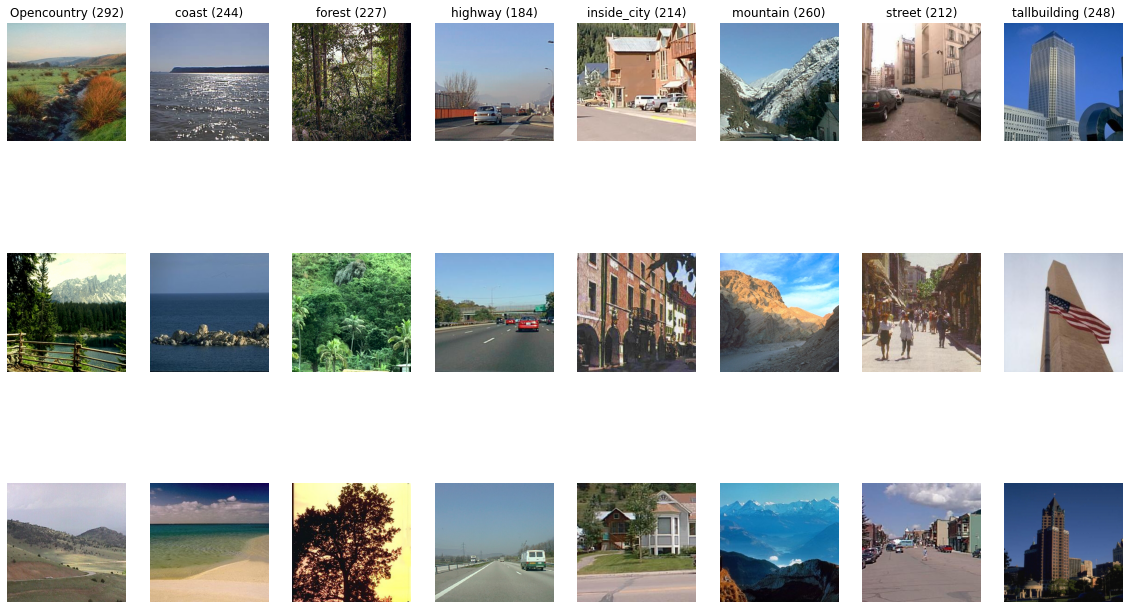

Testing set
Number of samples: 807


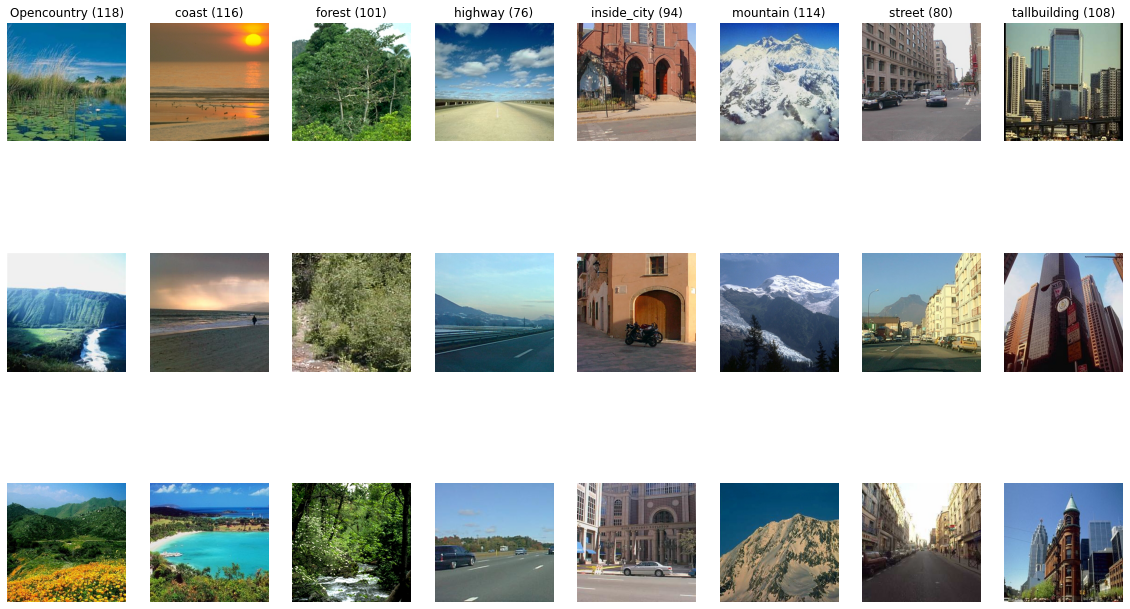

In [ ]:
def plot_dataset(image_filenames, labels, samples=3):

    print(f'Number of samples: {len(image_filenames)}')
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(20,12))
    
    for i, clase in enumerate(classes):
        indices = np.where(np.array(labels) == clase)[0]
        random_indices = np.random.choice(indices, samples, replace=False)
        for j, index in enumerate(random_indices):
            plt_idx = j * num_classes + i + 1
            plt.subplot(samples, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[index]))
            plt.axis('off')
            if j == 0:
                plt.title(f'{clase} ({len(indices)})')
    plt.show()

#For the training set
print('Training set')
plot_dataset(train_images_filenames, train_labels, 3)

#For the testing set
print('Testing set')
plot_dataset(test_images_filenames, test_labels, 3)

Let's start by creating a KAZE/SIFT/.... object detector and descriptor

In [ ]:
max_features = 500  #amount of max features (SIFT)
threshold=0.0005
#SIFT
Detector = cv2.SIFT_create(max_features)
#KAZE
#Detector = cv2.KAZE_create(threshold=threshold)

We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [ ]:
Train_descriptors = []
Train_label_per_descriptor = []

dense_sift = True #whether or not to use dense sift
average_amount_descriptors = 0
counter = 0
if not dense_sift:
  #For SIFT and KATE object detector and descriptor
  for filename,labels in zip(train_images_filenames,train_labels):
      ima=cv2.imread(filename)
      gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
      kp,des=Detector.detectAndCompute(gray,None)
      average_amount_descriptors = average_amount_descriptors + des.shape[0] 
      Train_descriptors.append(des)
      Train_label_per_descriptor.append(labels)
      counter = counter+1

  #print("Average amount of descriptors: ", average_amount_descriptors/counter)

else:
  step_size = 20 #this parameter must be tweaked
  #For Dense SIFT
  for filename,labels in zip(train_images_filenames,train_labels):
      ima=cv2.imread(filename)
      gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
      #compute keypoints using patches of the step size
      kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                          for x in range(0, gray.shape[1], step_size)]
                                    
      _, des = Detector.compute(gray, kp)
      Train_descriptors.append(des)
      Train_label_per_descriptor.append(labels)


D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [ ]:
#Test different amounts of codebook sizes k. What performs best?

k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [ ]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [ ]:
#Test different values of k for the k-nn classifier (n_neighbors). What performs best?
#Test other distances in k-nn classifier. Does that make a difference? Why?
parameters = {'metric':('manhattan', 'euclidean','chebyshev', 'minkowski',
                        'braycurtis', 'jaccard', 'canberra', 'cosine', 'cityblock', ) }
n_neighbors = 5 #by default ==5
knn = KNeighborsClassifier(n_neighbors = n_neighbors)
grid = GridSearchCV(knn, parameters, cv=8, scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)
grid.fit(visual_words, train_labels)

We end up computing the test descriptors and compute the accuracy of the model

In [ ]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
if not dense_sift:
  for i in range(len(test_images_filenames)):
      filename=test_images_filenames[i]
      ima=cv2.imread(filename)
      gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
      kpt,des=Detector.detectAndCompute(gray,None)
      words=codebook.predict(des)
      visual_words_test[i,:]=np.bincount(words,minlength=k)
else:
  for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=Detector.detectAndCompute(gray,None)
        dense_kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                          for x in range(0, gray.shape[1], step_size)]
                                    
        _, des = Detector.compute(gray, dense_kp)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)

In [ ]:
accuracy = 100*grid.score(visual_words_test, test_labels)
print("Accuracy " + str(accuracy))

# *Training results*
The parameters have been optimised sequentially, one at a time. In particular, the contents of this notebook have been automatised and iteratively run using different values in a separate script. Because of this, we may have come up with suboptimal solutions. Also, the cross-validation has been done with the 8 (stratified) fold cross-validation over the training data. In particular, this has been carried out using the function cross_validation of the library sklearn.
# **Results without PCA and LDA**
The parameters have been optimised sequentially, one at a time. Because of this, we may have come up with suboptimal solutions. Also, the cross-validation has been done with the 8 (stratified) fold cross-validation

## **Descriptor type**

**Using the KAZE descriptor to generate the features**, we can obtain more or less features by varying the threshold to detect a key point. The scores obtained can be seen below.


In [ ]:
#plots the accuracy, precision, recall, f1score and execution time given a .pkl file with said strucure
def plot_acc_pre_rec_f1_t(pickle, method_name, param_name, log=False):
    
    thresholds = pickle[0]
    print(thresholds)
    crossval_accuracies = pickle[1]
    crossval_precision = pickle[2]
    crossval_recall = pickle[3]
    crossval_f1 = pickle[4]
    t = pickle[5]

    plt.plot(thresholds, crossval_accuracies, label = "crossval_accuracy")
    plt.plot(thresholds, crossval_precision, label = "crossval_precision")
    plt.plot(thresholds,crossval_recall, label = "crossval_recall")
    plt.plot(thresholds, crossval_f1, label = "crossval_f1")

    plt.legend()
    ax = plt.gca()
    ax.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel(param_name)
    plt.title(str(method_name)+" scores")
    if log:
      ax.set_xscale('log')
    plt.show()
    plt.plot(thresholds, t)
    ax = plt.gca()
    ax.autoscale(enable=True, axis='x', tight=True)
    
    if log:
      ax.set_xscale('log')
    plt.ylabel("execution time (s)")
    plt.title(str(method_name)+" execution time")
    ax.set_ylim([0, 110])
    plt.xlabel(param_name)
    plt.show()

[0.0005, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10]


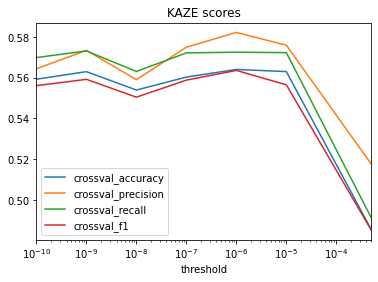

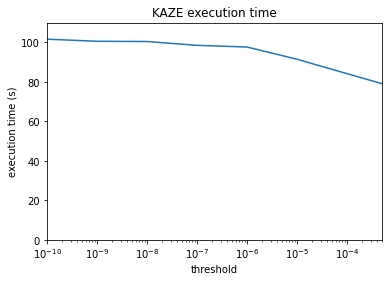

Max features  Accuracy  Precision    Recall        F1        t(s)
0  5.000000e-04  0.485415   0.517610  0.491237  0.485144   79.086984
1  1.000000e-05  0.563034   0.576011  0.572348  0.556528   91.441165
2  1.000000e-06  0.564082   0.582269  0.572569  0.563613   97.622938
3  1.000000e-07  0.560332   0.575016  0.572220  0.558840   98.476674
4  1.000000e-08  0.553969   0.559054  0.563091  0.550454  100.412532
5  1.000000e-09  0.563005   0.573459  0.573177  0.559223  100.525588
6  1.000000e-10  0.559290   0.564419  0.569924  0.556115  101.593528

In [ ]:
result_path = "."
#KAZE RESULTS
pickle_kaze_path = result_path + "/KAZE.pkl"
with open(pickle_kaze_path, 'rb') as f:
    pickle_kaze = pickle.load(f)
    
plot_acc_pre_rec_f1_t(pickle_kaze, "KAZE", "threshold", True)

pickle_kaze = np.array(pickle_kaze).T.tolist()

df = pd.DataFrame(pickle_kaze, columns = [ 'Max features', 'Accuracy', 'Precision', 'Recall', 'F1', 't(s)'])
display(df)  


**Using the SIFT descriptor to generate the features**, the results obtained are:

[100, 200, 500, 1500, 2000, 2500, 3000, 5000, 10000, 100000]


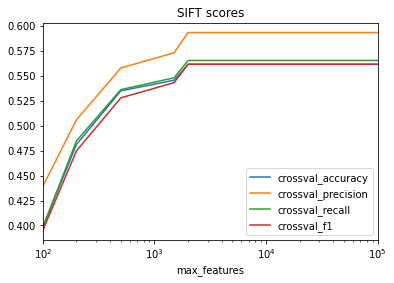

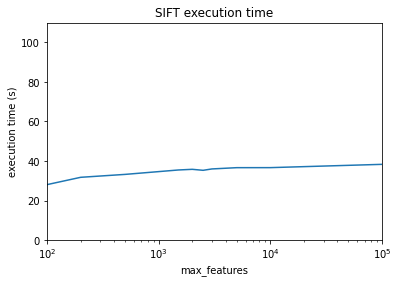

Max features  Accuracy  Precision    Recall        F1       t(s)
0         100.0  0.398199   0.439218  0.398266  0.395275  28.064707
1         200.0  0.481128   0.505818  0.484678  0.474659  31.760666
2         500.0  0.534847   0.557738  0.536071  0.527810  33.236469
3        1500.0  0.545467   0.572947  0.547896  0.543007  35.467994
4        2000.0  0.561425   0.593222  0.565251  0.561488  35.804046
5        2500.0  0.561425   0.593222  0.565251  0.561488  35.303012
6        3000.0  0.561425   0.593222  0.565251  0.561488  35.995081
7        5000.0  0.561425   0.593222  0.565251  0.561488  36.636654
8       10000.0  0.561425   0.593222  0.565251  0.561488  36.655608
9      100000.0  0.561425   0.593222  0.565251  0.561488  38.319726

In [ ]:
#SIFT RESULTS
pickle_sift_path = result_path + "/SIFT.pkl"
with open(pickle_sift_path, 'rb') as f:
    pickle_sift = pickle.load(f)
    
plot_acc_pre_rec_f1_t(pickle_sift, "SIFT", "max_features", True)
pickle_sift = np.array(pickle_sift).T.tolist()

df = pd.DataFrame(pickle_sift, columns = [ 'Max features', 'Accuracy', 'Precision', 'Recall', 'F1', 't(s)'])
display(df)  

In both cases, the more features are used, the better the performance is, until it reaches a certain threshold. After said threshold, the accuracy begins to decline in the case of KAZE. We believe that this is due to the fact that, depending on the image, a different amount of features is obtained. That means that some images may have higher amount of features which keeps rising if we keep allowing a bigger amount of them. This may decrease the quality of the words (clusters formed by a different amount of features depending on the image), giving worse results as a consequence. Another cause is the fact that the new features we are accepting are redundant.

Both cases present a two peaks in the accuracies separated by a decline. It is likely that the second peak is due to overfitting.


Another thing worth mentioning is that we are using two different strategies to increase the features in KAZE and SIFT. In KAZE, we are changing a threshold that determines whether or not to accept a feature, whereas in SIFT we are trimming the features that surpass a maximum value. This is why on the latter the score stops increasing or decreasing after reaching a second peak in accuracy: All of the images have an amount of features under max_features.  


For the experiments carried out from this point on, *only the SIFT descriptor has been used.* This is mainly because SIFT has obtained really similar results with a way smaller computational cost compared to KAZE.


## **Dense SIFT**

With dense sift we manage to preserve part of the local information, as we obtain features in user-defined blocks.

 Using the DENSE SIFT descriptor to generate the features, the results achieved and a plot of them can be see below:


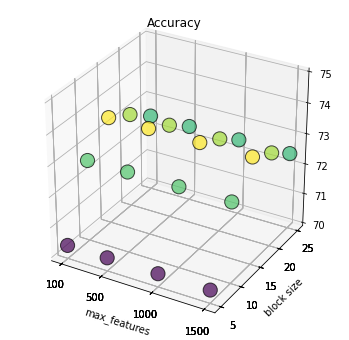

Block size  Max features  Accuracy  Precision    Recall        F1  \
0        100.0           5.0  0.703381   0.718995  0.704962  0.700242   
1        100.0          10.0  0.725694   0.731744  0.729552  0.723869   
2        100.0          15.0  0.734212   0.741734  0.738857  0.734346   
3        100.0          20.0  0.729907   0.744149  0.735015  0.732872   
4        100.0          25.0  0.724087   0.737437  0.728361  0.725956   
5        500.0           5.0  0.703381   0.718995  0.704962  0.700242   
6        500.0          10.0  0.725694   0.731744  0.729552  0.723869   
7        500.0          15.0  0.734212   0.741734  0.738857  0.734346   
8        500.0          20.0  0.729907   0.744149  0.735015  0.732872   
9        500.0          25.0  0.724087   0.737437  0.728361  0.725956   
10      1000.0           5.0  0.703381   0.718995  0.704962  0.700242   
11      1000.0          10.0  0.725694   0.731744  0.729552  0.723869   
12      1000.0          15.0  0.734212   0.741734  0.738857  0.734346   
13      1000.0          20.0  0.729907   0.744149  0.735015  0.732872   
14      1000.0          25.0  0.724087   0.737437  0.728361  0.725956   
15      1500.0           5.0  0.703381   0.718995  0.704962  0.700242   
16      1500.0          10.0  0.725694   0.731744  0.729552  0.723869   
17      1500.0          15.0  0.734212   0.741734  0.738857  0.734346   
18      1500.0          20.0  0.729907   0.744149  0.735015  0.732872   
19      1500.0          25.0  0.724087   0.737437  0.728361  0.725956   

         t(s)  
0   65.832348  
1   26.186655  
2   24.500379  
3   49.410094  
4   45.284168  
5   63.550268  
6   33.175448  
7   28.743454  
8   49.657887  
9   44.967948  
10  76.994089  
11  36.227260  
12  30.017527  
13  49.533205  
14  44.885917  
15  69.330949  
16  37.395903  
17  32.510092  
18  50.578799  
19  46.754761

In [ ]:
def plot_accuracy_maxfeat_step(pickle):
    
    x = pickle[0]#max_features
    z = pickle[2]
    z = [value * 100 for value in z]
    y = pickle[1]
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z,
               linewidths=1, alpha=.7,
               edgecolor='k',
               s = 200,
               c=z)
    ax = plt.gca()
    ax.set_zlim([70, 75])
    ax.set_xticks(x) 
    ax.set_yticks(y) 
    plt.ylabel('block size')
    plt.xlabel('max_features')
    plt.title('Accuracy')
    plt.show()

#DENSE SIFT RESULTS
result_path = '.'
pickle_dense_sift_path = result_path + "/DENSE_SIFT.pkl"
with open(pickle_dense_sift_path, 'rb') as f:
    pickle_dense_sift = pickle.load(f)

plot_accuracy_maxfeat_step(pickle_dense_sift)
 
pickle_dense_sift = np.array(pickle_dense_sift).T.tolist()

df = pd.DataFrame(pickle_dense_sift, columns = ['Block size', 'Max features', 'Accuracy', 'Precision', 'Recall', 'F1', 't(s)'])
display(df)  


As we can see, the best result is obtained using 20x20 size blocks. The accuracies obtained are also quite high in comparison to the ones obtained using the regular SIFT algorithm. Our parameter to trim the amount of features (max_features) is no longer used as the number of features is only reliant on the size of the image and blocks, so results do not vary regardless of changing it.

Letting the algorithm choose the keypoints on its own as it does in SIFT might prioritise features of detailed images such as textured backgrounds or edges, leaving classes that have rather flat, non-textured images underrepresented. An example of the keypoint retrieval of a coast image using SIFT and dense SIFT can be seen below.

As explained earlier, most of the keypoints retrieved automatically with SIFT are edges or textured areas like waves, while other sections like the sky end up are not represented with any keypoint. This is why using a block-based choice to determine the blocks greatly improved our results.



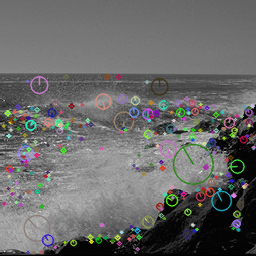

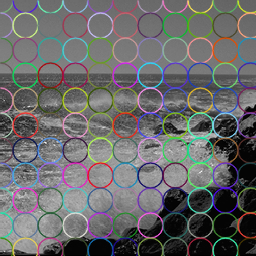

In [ ]:
example_path = filepath+"/MIT_split/test/coast/bea20.jpg"
ima=cv2.imread(example_path)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

kp,des=Detector.detectAndCompute(gray,None)
ima_kp=cv2.drawKeypoints(gray,kp,ima.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

step_size = 25
#compute keypoints using patches of the step size
kp_dense = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                    for x in range(0, gray.shape[1], step_size)]
                              
from google.colab.patches import cv2_imshow

ima_kp_DENSE=cv2.drawKeypoints(gray,kp_dense,ima.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(ima_kp)
cv2_imshow(ima_kp_DENSE)


##  **Different codebook sizes k**

Parameters: DENSE_SIFT , step_size = 20, n_neighbors = 5, distance = "euclidean"

Choosing a smaller codebook means that more features would be mapped into a single word. In contrast, making a codebook that is too large will map similar features in different words. That means that small codebooks will contain words that represent features that are way too different while larger codebooks defy the purpose of grouping features into words, as few features will be grouped into the same word. In this case, the data gets achieves best results with codebooks of size 128.


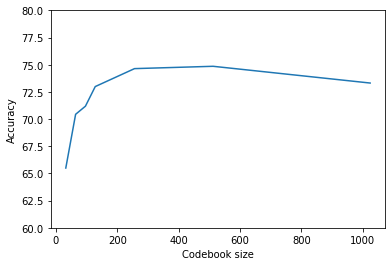

Codebook size   Accuracy  Precision    Recall        F1        t(s)
0            32.0  0.654968   0.663215  0.656944  0.651815   48.165564
1            64.0  0.704391   0.716098  0.706477  0.704108   48.552900
2            96.0  0.711846   0.729255  0.713618  0.713869   48.378635
3           128.0  0.729907   0.744149  0.735015  0.732872   49.115028
4           256.0  0.746412   0.755026  0.750099  0.746808   53.098790
5           512.0  0.748555   0.763046  0.753158  0.750337   72.428532
6          1024.0  0.733148   0.750498  0.739727  0.733973  148.980265

In [ ]:
pickle_codebook_path = result_path + "/codebook.pkl"
with open(pickle_codebook_path, 'rb') as f:
    pickle_codebook = pickle.load(f)
    
x = pickle_codebook[0]
y = pickle_codebook[1]

y = [value * 100 for value in y]
plt.plot(x, y)
ax = plt.gca()
ax.set_ylim([60, 80])
plt.ylabel('Accuracy')
plt.xlabel('Codebook size')
plt.show()

pickle_codebook = np.array(pickle_codebook).T.tolist()

df = pd.DataFrame(pickle_codebook, columns = ['Codebook size ', 'Accuracy', 'Precision', 'Recall', 'F1', 't(s)'])
display(df)  


## **Different number of n_neighbors**

Parameters: DENSE_SIFT, step_size = 20, codebook_size=128

| Parameters  |Accuracy | 
|-------------------|----------------- |
|  n_neighbors=2  | 66.9309 |
|  n_neighbors=3 |  72.5144 |
|  n_neighbors=4  |  72.6720 |
|  n_neighbors=5 |   72.9907|
|  n_neighbors=6  |  73.0968 |
|  n_neighbors=7 |  73.3116 |
|   n_neighbors=8 |  74.5339 |
|   n_neighbors=9 |  74.3214 |
|   **n_neighbors=10** | **74.8533**  |
|   n_neighbors=16 | 74.6414  |
|   n_neighbors=32 |  73.6314 |
|   n_neighbors=64 | 73.7903  |
|   n_neighbors=128 | 73.3653  |

This time we are analysing the effects caused on the boundaries of the final classification. The amount of neighbours affects to the smoothness of said boundaries. A smaller amount of neighbours will make them follow the data points finely, whereas a bigger value will smooth them out.


## **Different distances in the knn classifier**
Testing different distance does not change the results that much except for some distances that worsen the performance such as the Chebyshev distance.

| Parameters  |Accuracy | 
|-------------------|----------------- |
| manhattan   | 0.755984 |
| euclidean    |  0.729907 |
| chebyshev    |  0.652310 |
|  minkowski    | 0.729907 |
|  braycurtis   | 0.755984  |
|  jaccard  |  0.703349 |
|   canberra   | 0.665076  |
|   cosine     |  0.729404 |
|   cityblock     |  0.755984 |
|

Dimensionality reduction, with PCA and LDA

In [ ]:
#Play with reducing dimensionality
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

# **Results reducing dimensionality with PCA and LDA**
Decreasing the redundancy of the data may help improve our results. However, like the examples above, we will find a tradeoff. In this case, reducing the dimensionality too much might remove data that is not redundant, while not reducing the dimensionality will make this step useless.
## **Different n_components in PCA**

Typically, we want the variance between 95-99% [[PCA — how to choose the number of components?](https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/)]. With the scikit implementation, we can either select the amount of variance or manually choose the amount of components.
However, we noticed that using crossvalidation with the train data, the outputted result is always the same with both approaches:

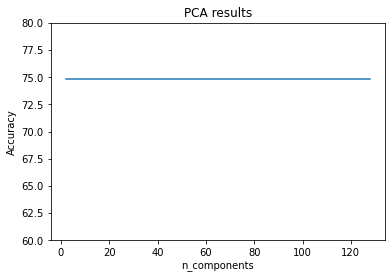

n_components   Accuracy  Precision    Recall       F1       t(s)
0            2.0  0.748533   0.764497  0.753305  0.75158  80.590447
1            4.0  0.748533   0.764497  0.753305  0.75158  81.963154
2            8.0  0.748533   0.764497  0.753305  0.75158  80.317084
3           16.0  0.748533   0.764497  0.753305  0.75158  80.208707
4           32.0  0.748533   0.764497  0.753305  0.75158  82.306393
5           64.0  0.748533   0.764497  0.753305  0.75158  81.861083
6           96.0  0.748533   0.764497  0.753305  0.75158  82.361560
7          128.0  0.748533   0.764497  0.753305  0.75158  80.409421

In [ ]:
import matplotlib.pyplot as plt
pickle_PCA_path = result_path + "/PCA_number_bigger_1.pkl"
with open(pickle_PCA_path, 'rb') as f:
    pickle_PCA = pickle.load(f)
    
x = pickle_PCA[0]
y = pickle_PCA[1]

y = [value * 100 for value in y]
plt.plot(x, y)
ax = plt.gca()
ax.set_ylim([60, 80])
plt.ylabel('Accuracy')
plt.xlabel('n_components')
plt.title("PCA results")
plt.show()

pickle_PCA = np.array(pickle_PCA).T.tolist()

df = pd.DataFrame(pickle_PCA, columns = ['n_components ', 'Accuracy', 'Precision', 'Recall', 'F1', 't(s)'])
display(df)  

Using LDA, the results have also been the same:

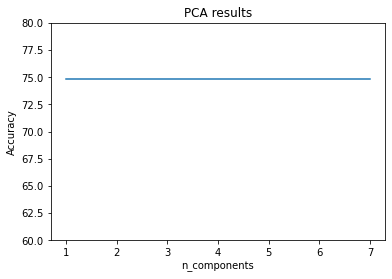

n_components   Accuracy  Precision    Recall       F1       t(s)
0            1.0  0.748533   0.764497  0.753305  0.75158  81.970924
1            2.0  0.748533   0.764497  0.753305  0.75158  78.925111
2            3.0  0.748533   0.764497  0.753305  0.75158  81.959008
3            4.0  0.748533   0.764497  0.753305  0.75158  80.827972
4            5.0  0.748533   0.764497  0.753305  0.75158  79.573961
5            6.0  0.748533   0.764497  0.753305  0.75158  78.866699
6            7.0  0.748533   0.764497  0.753305  0.75158  78.541176

In [ ]:
pickle_LDA_path = result_path + "/LDA.pkl"
with open(pickle_LDA_path, 'rb') as f:
    pickle_LDA = pickle.load(f)
    
x = pickle_LDA[0]
y = pickle_LDA[1]

y = [value * 100 for value in y]
plt.plot(x, y)
ax = plt.gca()
ax.set_ylim([60, 80])
plt.ylabel('Accuracy')
plt.xlabel('n_components')
plt.title("PCA results")
plt.show()

pickle_LDA = np.array(pickle_LDA).T.tolist()

df = pd.DataFrame(pickle_LDA, columns = ['n_components ', 'Accuracy', 'Precision', 'Recall', 'F1', 't(s)'])
display(df) 

This can be due to two different reasons. On the one hand, maybe our data can not be reduced further. On the other hand, since test results have been different depending on our number of components, there may be a discrepancy in our way to crossvalidate this data while modifying the number of components.



# *Test Results*

## **Test results with PCA**
Using the variance directly as a cutoff, with our data, the best result is obtained using 96%. 

Parameters: DENSE SIFT, step_size = 20, codebook = 128,  nfeatures = 1000, n_neighbors = 10, distance = "minkowski"

| Parameters  |Accuracy | 
|-------------------|----------------- |
|   n_components=0.95 | 77.57125154894672 |
|   0.96  |  77.69516728624535 |
|    0.97 |  78.1908302354399 |
|    0.98  | 78.06691449814126 |
|    0.99 | 77.19950433705081  |


 If we try running it choosing the amount of components ourselves, we see that keeping about 96 of the dimensions is what performs best.

| Parameters  |Accuracy | 
|-------------------|----------------- |
|   2 | 60.470879801734824 |
|   4  |  70.26022304832715 |
|   8  |  70.87980173482032 |
|    16  | 75.21685254027261 |
|    32 |  76.95167286245353 |
|   64 | 76.95167286245353 |
|   96  |  78.31474597273854 |
|   128  |  77.19950433705081 |



## **Test results with LDA**
Parameters: DENSE SIFT, step_size = 20, codebook = 128,  nfeatures = 1000, n_neighbors = 10, distance = "minkowski"

| Parameters  |Accuracy | 
|-------------------|----------------- |
|   1 | 35.43990086741016 |
|   2  | 60.84262701363073  |
|   3  |  71.74721189591078 |
|    4  | 76.70384138785626 |
|   5  | 78.1908302354399  |
|   6 | 76.70384138785626  |
|   7  | 80.29739776951673  |

Using LDA gave us slightly better results than PCA. The main different between those algorithms is that PCA is an unsupervised algorithm whereas LDA is supervised. In particular, PCA finds directions of maximum variance and LDA finds directions of maximum class separability [[PCA vs LDA Differences, Plots, Examples](https://vitalflux.com/pca-vs-lda-differences-plots-examples/#:~:text=PCA%20is%20an%20unsupervised%20learning,directions%20of%20maximum%20class%20separability.)]. Since we are carrying out a classification task where we know the amount of classes beforehand, it makes sense that LDA is slightly better for our application, as we are trying to separate specific classes.

Since our test results using dimensionality reduction with the test data have outperformed the ones of the cross-validated train data, we can conclude that our final system is not overfitting and generalises well. 

# **Conclusions**
With this project we have learnt how by adding local information to our descriptors (Dense sift), tweaking the parameters of each step of our pipeline and reducing the redundancy of our data we can improve our results greatly. Moreover, it is crucial to choose the parameters precisely depending on the scenario where our classifier will work on, since most parameters have a trade-off between high quality results and computational cost.
